<a href="https://colab.research.google.com/github/geijinchan/MultiModal-RAG-trying-with-open-source-models/blob/main/MultiModal_RAG_trying_wiht_open_source_models_yt_working.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Multimodal RAG App for Video Processing with LlamaIndex and LaneDB

1. llamaindex Framework
2. Lancedb Vector Database
3. LLM MultiModalAi GPT-4V or Google-gemini-pro-vision

### Steps Need to follow:
1. Download video from Youtube, process and store it.
2. Build Multi-Modal index and vector store for both text and images.
3. Retrieve relenavet images and context, use both to augment the prompt.
4. Using GPT4V for reasoning the correlation between the input query and augmented data and generate final response.

#### Installing Necessary Dependencies

In [ ]:
%pip install llama-index-vector-stores-lancedb
%pip install llama-index-multi-modal-llms-openai
%pip install llama-index-embeddings-clip
%pip install git+https://github.com/openai/CLIP.git
!pip install llama-index-readers-file
!pip install llama-index-embeddings-openai
%pip install lancedb
%pip install llama-index lancedb transformers ftfy regex tqdm
%pip install moviepy
%pip install pytube
%pip install pytubefix
%pip install pydub
%pip install SpeechRecognition
%pip install ffmpeg-python
%pip install soundfile
%pip install torch torchvision
%pip install matplotlib scikit-image
%pip install ftfy regex tqdm
%pip install openai-whisper

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-dnmrdlw0
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-dnmrdlw0
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 29.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.4/187.4 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.8/32.8 MB 54.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 798.6/798.6 kB 16.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for openai-whisper: filename=openai_whisp

In [ ]:
from moviepy.editor import VideoFileClip
from pathlib import Path
from pytube import YouTube
from pytubefix import YouTube
from pytubefix.cli import on_progress
from moviepy.editor import VideoFileClip
import speech_recognition as sr
from pprint import pprint
from PIL import Image
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'pytube'

ffmpeg-library enables you to use FFmpeg in Python to manipulate various media files for different purposes like building comprehensive multimedia applications, preprocessing media files.


Pydub is a Python library for audio manipulation, enabling easy loading, editing, and exporting of audio files in various formats with minimal code.

SoundFile is a Python library for reading from and writing to audio files, supporting many formats through the libsndfile library, ideal for high-quality audio processing.

FTFY (Fix Text For You) is a Python library that fixes broken Unicode text and mojibake (garbled text due to encoding issues), making text legible again.

OpenAI Whisper is a robust, multilingual speech recognition model developed by OpenAI. It converts speech into text and supports various languages with high accuracy.

pprint is a Python module that provides a capability to "pretty-print" complex data structures in a well-formatted and more readable way than the basic print function.

In [ ]:
import os
from google.colab import userdata
OPENAI_API_TOKEN=userdata.get('OPENAI_API_KEY')
os.environ["OPENAI_API_KEY"] = OPENAI_API_TOKEN

In [ ]:
video_url='https://youtu.be/3dhcmeOTZ_Q'
output_video_path = "/content/video_data/"

# From the video lets collect images, audio and text
output_folder = "/content/mixed_data/"
output_audio_path = "/content/mixed_data/output_audio.wav"

!mkdir mixed_data

filepath=output_video_path + "input_vid.mp4"
print(filepath)

/content/video_data/input_vid.mp4


#### 1.1 Downloading the video

Pytube is a Python library used for downloading videos from YouTube. It supports downloading in various formats, resolutions, and also direct audio extraction.

In [ ]:
def download_video(url,output_path):
  yt = YouTube(video_url, on_progress_callback = on_progress)
  metadata = {"Author": yt.author, "Title": yt.title, "Views": yt.views}
  yt.streams.get_highest_resolution().download(output_path=output_video_path,
                                               filename="input_vid.mp4")
  return metadata

#### 1.2 Video to image

MoviePy is a Python library for video editing, enabling cutting, concatenations, title insertions, video compositing, and effects like animations or color grading.

In [ ]:
def video_to_images(video_path,output_folder):
  clip=VideoFileClip(video_path)
  clip.write_images_sequence(
      os.path.join(output_folder,"frame%04d.png"),fps=0.2   #0.2 frames per second (fps) is equal to 2/10 of a frame per second
  )

#### 1.3 Video to audio

In [ ]:
def video_to_audio(video_path,output_audio_path):
  clip=VideoFileClip(video_path)
  audio=clip.audio
  audio.write_audiofile(output_audio_path)

#### 1.4 Audio to text

The SpeechRecognition library in Python allows you to convert spoken language into text using various engines and APIs, such as Google Speech Recognition, IBM Speech to Text, etc.

In [ ]:
def audio_to_text(audio_path):
  recognizer=sr.Recognizer()
  audio=sr.AudioFile(audio_path)

  with audio as source:
    audio_data=recognizer.record(source)

    try:

      #recognize the speech
      text = recognizer.recognize_whisper(audio_data)

    except sr.UnknownValueError:
      print("Speech recognition could not understand the audio.")
  return text


In [ ]:
metadata_vid = download_video(video_url, output_video_path)

VideoUnavailable: [91m3dhcmeOTZ_Q is unavailable[0m

In [ ]:
metadata_vid = download_video(video_url, output_video_path)
video_to_images(filepath,output_folder)
video_to_audio(filepath,output_audio_path)
text_data=audio_to_text(output_audio_path)
text_data

Moviepy - Writing frames /content/mixed_data/frame%04d.png.


Moviepy - Done writing frames /content/mixed_data/frame%04d.png.
MoviePy - Writing audio in /content/mixed_data/output_audio.wav


MoviePy - Done.


100%|███████████████████████████████████████| 139M/139M [00:01<00:00, 81.9MiB/s]


" Lanyard regression is a statistical technique for modeling the relationship between an output variable and one or more input variables. In layman's terms, think of it as fitting a line through some data points as shown here, so you can make predictions on unknown data, assuming there is a linear relationship between the variables. You might be familiar with the linear function y equals mx plus b, where y is the output variable, also called the dependent variable. You may also see expressed as f of x, the function of the input variable. x on the other hand, would serve as the input variable, also called the independent variable. It's likely you'll see the coefficients m and b expressed as beta 1 and beta 0 respectively. So what do the m and b coefficients do? The m or beta 1 coefficient controls the slope of the line. The b or the beta 0 controls the intercept of the line. In machine learning, we also know it as the bias. These two coefficients are what we are solving for in linear re

In [ ]:
with open(output_folder + "output_text.txt", "w") as file:
        file.write(text_data)
print("Text data saved to file")
file.close()
os.remove(output_audio_path)
print("Audio file removed")

Text data saved to file
Audio file removed


## 2 Build Multi-Modal index and vector store for both text and images.

#### Load the data

To proceed with embedding the extracted frames and storing them as vectors in FAISS, we'll use a model like CLIP to embed both images (frames) and text data. Then, we'll store these embeddings in FAISS for efficient retrieval.

### Step-by-Step Guide:
1. Embed Images (Frames) Using CLIPbed Images (Frames) Using CLIP

CLIP (Contrastive Language–Image Pretraining) is an open-source model that can generate embeddings for both images and text. We'll use it to embed the extracted frames.

In [ ]:
import whisper

def audio_to_text(audio_path):
    model = whisper.load_model("base")  # Load the base Whisper model
    audio, sr_freq = whisper.load_audio(audio_path)  # Load the audio file
    result = model.transcribe(audio)  # Transcribe the audio using Whisper
    return result["text"]

## Final working

In [ ]:
# Only text part is working

"""# Image processing functions
def load_and_group_images(directory, batch_size=3):
    grouped_images = [images[i:i + batch_size] for i in range(0, len(images), batch_size)]
    return grouped_images

def encode_image_batch(image_batch):
    inputs = processor(images=image_batch, return_tensors="pt", padding=True, truncation=True)
    with torch.no_grad():
        image_features = model.get_image_features(**inputs)
    return image_features.cpu().numpy()

# Text processing functions
def text_to_wordList(text_data):
    words = word_tokenize(text_data)
    cleaned_words = [word for word in words if word not in {',', '.'}]
    max_words_per_list = 40
    return [cleaned_words[i:i + max_words_per_list] for i in range(0, len(cleaned_words), max_words_per_list)]

def encode_and_normalize_text_lists(text_lists):
    text_chunks = [" ".join(sublist) for sublist in text_lists]
    inputs = processor(text=text_chunks, return_tensors="pt", padding=True, truncation=True, max_length=77)
    with torch.no_grad():
        text_features = model.get_text_features(**inputs).cpu().numpy()
    text_features /= np.linalg.norm(text_features, axis=1, keepdims=True)
    return text_features

# Combined embedding and indexing
def create_combined_index(image_directory, text_data):
    # Process images
    grouped_images = load_and_group_images(image_directory)
    image_embeddings = np.vstack([encode_image_batch(img_batch) for img_batch in grouped_images])

    # Process text
    word_lists = text_to_wordList(text_data)
    text_embeddings = encode_and_normalize_text_lists(word_lists)

    # Combine embeddings
    combined_embeddings = np.hstack([text_embeddings, image_embeddings.reshape(text_embeddings.shape[0], -1)])

    # Create Faiss index
    dimension = combined_embeddings.shape[1]
    index = faiss.IndexFlatIP(dimension)
    index.add(combined_embeddings)

    return index, word_lists, grouped_images

# Query function
def query_combined_index(index, query_text, k=5, threshold=0.5):
    query_embedding = encode_and_normalize_text_lists([[query_text]])
    query_embedding_padded = np.hstack([query_embedding, np.zeros((1, index.d - query_embedding.shape[1]))])
    D, I = index.search(query_embedding_padded, k)
    return [(i, D[0][idx]) for idx, i in enumerate(I[0]) if D[0][idx] > threshold]

# Retrieval function
def retrieve_text_and_images(indices, word_lists, grouped_images):
    results = []
    for idx, similarity in indices:
        text = ' '.join(word_lists[idx])
        images = grouped_images[idx]
        results.append({
            'text': text,
            'images': images,
            'similarity': similarity
        })
    return results

# Main execution

# Create the combined index
index, word_lists, grouped_images = create_combined_index(image_files, text_data)

# Example query
query_text = "O'reilly"
matched_indices = query_combined_index(index, query_text)

# Retrieve results
results = retrieve_text_and_images(matched_indices, word_lists, grouped_images)

# Print results
for i, result in enumerate(results):
    print(f"Match {i+1}:")
    print(f"Text: {result['text']}")
    print(f"Number of images: {len(result['images'])}")
    print(f"Similarity: {result['similarity']:.4f}")
    print()"""

'# Image processing functions\ndef load_and_group_images(directory, batch_size=3):\n    grouped_images = [images[i:i + batch_size] for i in range(0, len(images), batch_size)]\n    return grouped_images\n\ndef encode_image_batch(image_batch):\n    inputs = processor(images=image_batch, return_tensors="pt", padding=True, truncation=True)\n    with torch.no_grad():\n        image_features = model.get_image_features(**inputs)\n    return image_features.cpu().numpy()\n\n# Text processing functions\ndef text_to_wordList(text_data):\n    words = word_tokenize(text_data)\n    cleaned_words = [word for word in words if word not in {\',\', \'.\'}]\n    max_words_per_list = 40\n    return [cleaned_words[i:i + max_words_per_list] for i in range(0, len(cleaned_words), max_words_per_list)]\n\ndef encode_and_normalize_text_lists(text_lists):\n    text_chunks = [" ".join(sublist) for sublist in text_lists]\n    inputs = processor(text=text_chunks, return_tensors="pt", padding=True, truncation=True, ma

## Copy

In [1]:
# Working fine

%pip install annoy
%pip install sentence-transformers
%pip install moviepy
%pip install pydub
%pip install openai-whisper
%pip install SpeechRecognition
%pip install faiss-cpu
%pip install openai-whisper
%pip install groq
%pip install yt-dlp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 16.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for annoy: filename=annoy-1.17.3-cp310-cp310-linux_x86_64.whl size=552451 sha256=c7b32725864304bef66ad8dfee5825ce4565ba23c8759885b363c26a5b13c9ad
  Stored in directory: /root/.cache/pip/wheels/64/8a/da/f714bcf46c5efdcfcac0559e63370c21abe961c48e3992465a
Successfully built annoy
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.3/245.3 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 800.5/800.5 kB 44.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.4/209.4 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 59.8 MB/s eta 0:00:00
  Created wheel for openai-whisper: filename=openai_whisper-20240930-py3-none-any.whl size=803321 sha256=5a760358b5c440ee629a4

In [2]:
# Working fine

import whisper
import os
from sentence_transformers import SentenceTransformer, util
from PIL import Image
import torch
import glob
from annoy import AnnoyIndex
from moviepy.editor import VideoFileClip
from pathlib import Path
from yt_dlp import YoutubeDL
from moviepy.editor import VideoFileClip
import speech_recognition as sr
from pprint import pprint
 # Install the CPU version of Faiss
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize, word_tokenize
import faiss
from tqdm import tqdm
from transformers import CLIPTokenizer
import numpy as np
from natsort import natsorted
import matplotlib.pyplot as plt
from transformers import CLIPProcessor, CLIPModel

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [3]:
# Working fine
video_url = "https://youtu.be/3dhcmeOTZ_Q"
output_video_path = "/content/video_data/"
output_folder = "/content/mixed_data/"
output_audio_path = os.path.join(output_folder, "output_audio.wav")

# Ensure output directories exist
os.makedirs(output_folder, exist_ok=True)
os.makedirs(output_video_path, exist_ok=True)

# Path to the downloaded video
filepath = os.path.join(output_video_path, "input_vid.mp4")
print(f"Expected video file path: {filepath}")

def download_video(video_url, output_folder):
    try:
        # yt-dlp options for downloading the best video+audio combined
        ydl_opts = {
            'format': 'bestvideo+bestaudio/best',  # Downloads best video with best audio, combining if necessary
            'outtmpl': os.path.join(output_folder, 'input_vid.%(ext)s'),  # Save with the appropriate extension
            'noplaylist': True,  # Ensures only a single video is downloaded, not a playlist
            'quiet': True,  # Prevents printing of unnecessary information
            'no_warnings': True,  # Suppress warning messages
        }

        with YoutubeDL(ydl_opts) as ydl:
            info = ydl.extract_info(video_url, download=True)  # Download video + audio
            filename = ydl.prepare_filename(info)  # The actual filename with extension

        # Extract metadata similar to your original code
        metadata = {
            "Author": info.get("uploader", "Unknown"),
            "Title": info.get("title", "Untitled"),
            "Views": info.get("view_count", 0)
        }

        print(f"Video file downloaded: {filename}")
        return filename, metadata

    except Exception as e:
        print(f"Error downloading video from {video_url}: {str(e)}")
        return None, None


def video_to_images(video_path, output_folder):
    clip = VideoFileClip(video_path)
    clip.write_images_sequence(
        os.path.join(output_folder, "frame%04d.png"), fps=0.2  # 0.2 frames per second (fps)
    )
    print(f"Images saved to {output_folder}")


def video_to_audio(video_path, output_audio_path):
    clip = VideoFileClip(video_path)
    audio = clip.audio
    audio.write_audiofile(output_audio_path)
    print(f"Audio extracted to {output_audio_path}")


def audio_to_text(audio_path):
    # Check if GPU is available, otherwise fallback to CPU
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device}")

    # Load the Whisper model and send it to the correct device (GPU/CPU)
    model = whisper.load_model("medium", device=device)

    # Transcribe the audio file
    result = model.transcribe(audio_path)

    # Return the transcribed text
    return result['text']


# Download video and get metadata
filename, metadata_vid = download_video(video_url, output_video_path)
if metadata_vid:
    print("Downloaded video metadata:")
    print(metadata_vid)

    # Check if the file has a .mkv extension and rename if necessary
    if filename.endswith(".mkv"):
        new_filepath = os.path.join(output_video_path, "input_vid.mkv")
        os.rename(filename, new_filepath)
        filepath = new_filepath  # Update the filepath to the correct extension
    else:
        filepath = filename  # Use the actual filename as downloaded

    print(f"Actual video file path: {filepath}")

    # Process the video: extract images, audio, and text
    video_to_images(filepath, output_folder)
    video_to_audio(filepath, output_audio_path)
    text_data = audio_to_text(output_audio_path)

    # Save the transcribed text to a file
    with open(os.path.join(output_folder, "output_text.txt"), "w") as file:
        file.write(text_data)
    print("Text data saved to file")

    # Cleanup: Remove the audio file
    os.remove(output_audio_path)
    print("Audio file removed")

    # Backup the text data if needed
    data_backup = text_data
else:
    print("Failed to download video.")


Expected video file path: /content/video_data/input_vid.mp4
Video file downloaded: /content/video_data/input_vid.mkv
Downloaded video metadata:
{'Author': '3-Minute Data Science', 'Title': 'Linear Regression in 3 Minutes', 'Views': 10117}
Actual video file path: /content/video_data/input_vid.mkv
Moviepy - Writing frames /content/mixed_data/frame%04d.png.


Moviepy - Done writing frames /content/mixed_data/frame%04d.png.
Images saved to /content/mixed_data/
MoviePy - Writing audio in /content/mixed_data/output_audio.wav


MoviePy - Done.
Audio extracted to /content/mixed_data/output_audio.wav
Using device: cuda


100%|█████████████████████████████████████| 1.42G/1.42G [00:28<00:00, 54.4MiB/s]
  checkpoint = torch.load(fp, map_location=device)



Text data saved to file
Audio file removed


In [4]:
text_data

" Linear regression is a statistical technique for modeling the relationship between an output variable and one or more input variables. In layman's terms, think of it as fitting a line through some data points as shown here so you can make predictions on unknown data, assuming there is a linear relationship between the variables. You might be familiar with the linear function y equals mx plus b, where y is the output variable, also called the dependent variable. You may also see it expressed as f of x, the function of the input variable. X on the other hand would serve as the input variable, also called the independent variable. It's likely you'll see the coefficients m and b expressed as beta 1 and beta 0 respectively. So what do the m and b coefficients do? The m, or beta 1 coefficient, controls the slope of the line. The b, or the beta 0, controls the intercept of the line. In machine learning, we also know it as the bias. These two coefficients are what we are solving for in linea

The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(



config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

  warnings.warn(



Match 1:
Text: I also do teach on the O'Reilly platform Promotional link below I teach classes including machine learning from scratch probability and SQL Comment on what topics you would like to see next and I will see you again on 3
Number of images: 3
Similarity: 0.7963

Displaying images for Match 1:


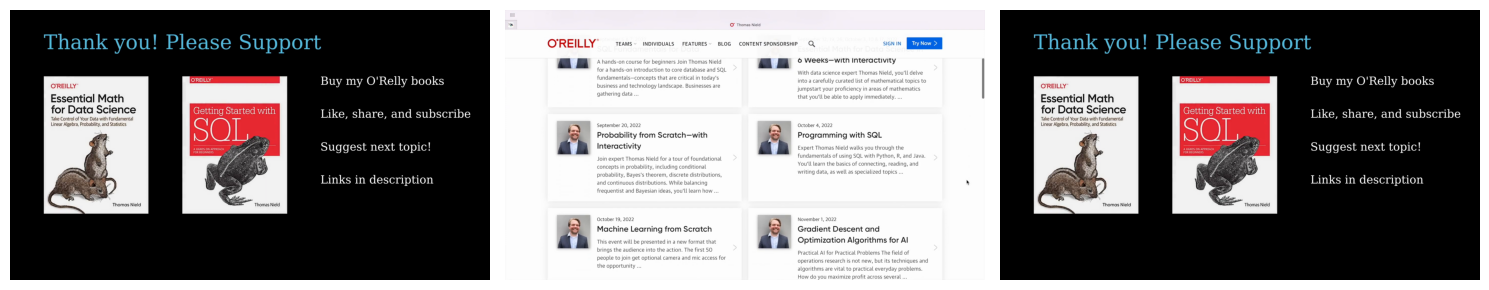

Match 2:
Text: Minute Data Science
Number of images: 2
Similarity: 0.7908

Displaying images for Match 2:


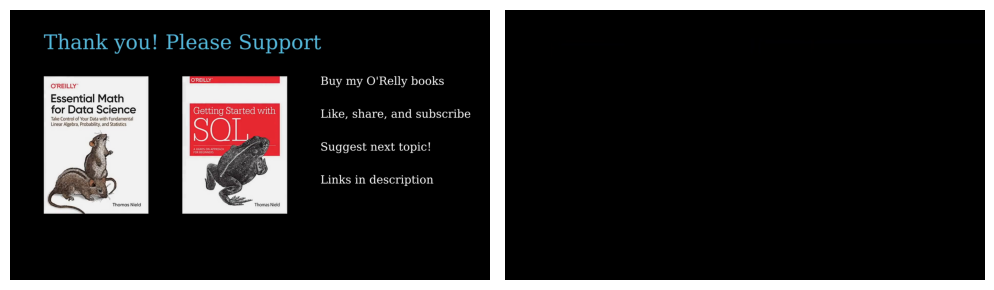

Match 3:
Text: may also see it expressed as f of x the function of the input variable X on the other hand would serve as the input variable also called the independent variable It 's likely you 'll see the coefficients m
Number of images: 3
Similarity: 0.7413

Displaying images for Match 3:


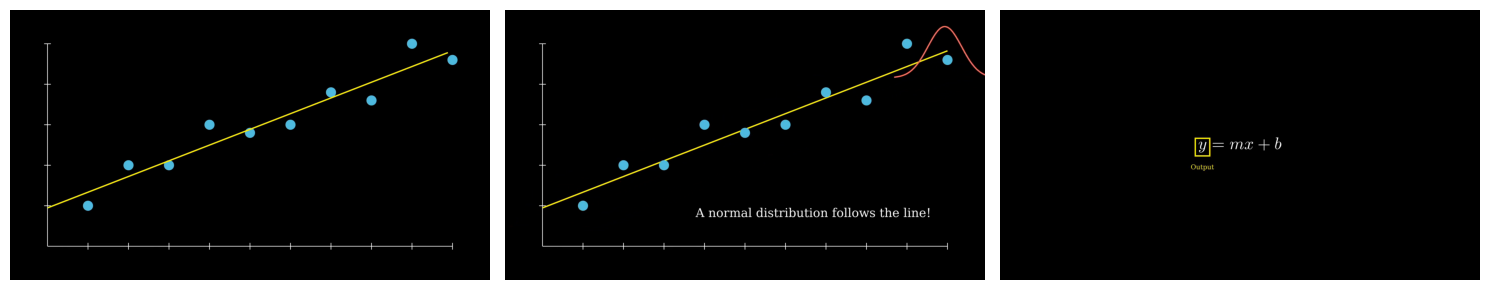

Match 4:
Text: training dataset The training dataset will then be used to fit the regression line The test dataset will then be used to validate the regression line This is done to make sure that the regression performs well on data it
Number of images: 3
Similarity: 0.7410

Displaying images for Match 4:


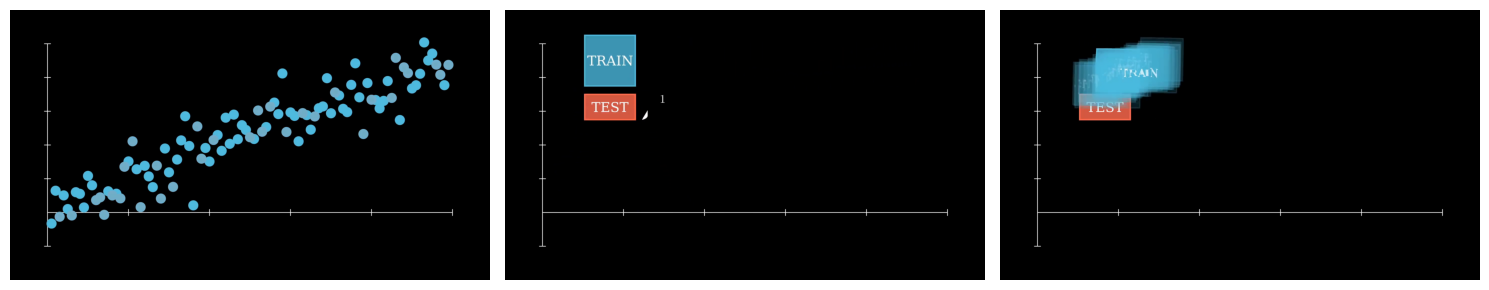

Match 5:
Text: ? Well you 'll notice that there 's these differences between the points and the line these little red segments these are called residuals They are the differences between the data points and the predictions the line would produce Take
Number of images: 3
Similarity: 0.7280

Displaying images for Match 5:


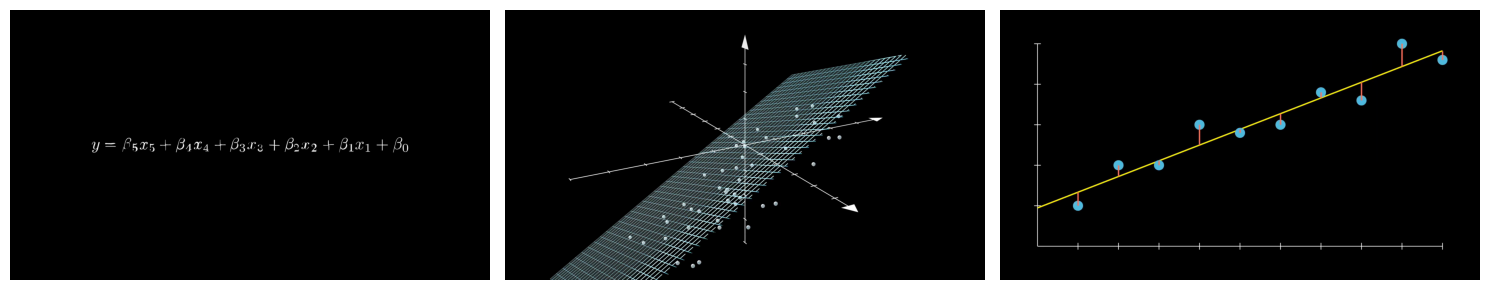

In [5]:
# Final working

# Load the CLIP model and processor
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Image processing functions
def load_and_group_images(images, batch_size=3):
    grouped_images = [images[i:i + batch_size] for i in range(0, len(images), batch_size)]
    return grouped_images

def encode_image_batch(image_batch):
    inputs = processor(images=image_batch, return_tensors="pt", padding=True, truncation=True)
    with torch.no_grad():
        image_features = model.get_image_features(**inputs)
    return image_features.cpu().numpy()

# Text processing functions
def text_to_wordList(text_data):
    words = word_tokenize(text_data)
    cleaned_words = [word for word in words if word not in {',', '.'}]
    max_words_per_list = 40
    return [cleaned_words[i:i + max_words_per_list] for i in range(0, len(cleaned_words), max_words_per_list)]

def encode_and_normalize_text_lists(text_lists):
    text_chunks = [" ".join(sublist) for sublist in text_lists]
    inputs = processor(text=text_chunks, return_tensors="pt", padding=True, truncation=True, max_length=77)
    with torch.no_grad():
        text_features = model.get_text_features(**inputs).cpu().numpy()
    text_features /= np.linalg.norm(text_features, axis=1, keepdims=True)
    return text_features

# Combined embedding and indexing
def create_combined_index(image_directory, text_data):
    # Process images
    grouped_images = load_and_group_images(image_directory)
    image_embeddings = np.vstack([encode_image_batch(img_batch) for img_batch in grouped_images])

    # Process text
    word_lists = text_to_wordList(text_data)
    text_embeddings = encode_and_normalize_text_lists(word_lists)

    # Combine embeddings
    combined_embeddings = np.hstack([text_embeddings, image_embeddings.reshape(text_embeddings.shape[0], -1)])

    # Create Faiss index
    dimension = combined_embeddings.shape[1]
    index = faiss.IndexFlatIP(dimension)
    index.add(combined_embeddings)

    return index, word_lists, grouped_images

# Query function
def query_combined_index(index, query_text, k=5, threshold=0.5):
    query_embedding = encode_and_normalize_text_lists([[query_text]])
    query_embedding_padded = np.hstack([query_embedding, np.zeros((1, index.d - query_embedding.shape[1]))])
    D, I = index.search(query_embedding_padded, k)
    return [(i, D[0][idx]) for idx, i in enumerate(I[0]) if D[0][idx] > threshold]

# Retrieval function
def retrieve_text_and_images(indices, word_lists, grouped_images, image_files):
    results = []
    for idx, similarity in indices:
        text = ' '.join(word_lists[idx])
        images = grouped_images[idx]
        image_paths = image_files[idx*3:(idx+1)*3]  # Get the corresponding image file paths
        results.append({
            'text': text,
            'images': images,
            'image_paths': image_paths,
            'similarity': similarity
        })
    return results

# New function to display images
def display_images(images, num_cols=3):
    num_images = len(images)
    num_rows = (num_images - 1) // num_cols + 1

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))

    if num_rows == 1 and num_cols == 1:
        axes = np.array([axes])
    elif num_rows == 1 or num_cols == 1:
        axes = axes.ravel()

    for i, img in enumerate(images):
        if isinstance(img, Image.Image):
            axes[i].imshow(img)
        elif isinstance(img, str):
            axes[i].imshow(Image.open(img))
        else:
            axes[i].imshow(img)  # Assume it's a numpy array or something imshow can handle
        axes[i].axis('off')

    # Hide any unused subplots
    for i in range(num_images, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()


image_files = glob.glob("mixed_data/*.png")
image_files = natsorted(image_files)
images = [Image.open(file) for file in image_files]

# Create the combined index
index, word_lists, grouped_images = create_combined_index(images, text_data)

# Example query
query_text = "O'reilly"
matched_indices = query_combined_index(index, query_text)

# Retrieve results
results = retrieve_text_and_images(matched_indices, word_lists, grouped_images,images)

# Print results and display images
for i, result in enumerate(results):
    print(f"Match {i+1}:")
    print(f"Text: {result['text']}")
    print(f"Number of images: {len(result['images'])}")
    #print(f"Image paths: {result['image_paths']}")
    print(f"Similarity: {result['similarity']:.4f}")
    print()

    # Display the images
    print(f"Displaying images for Match {i+1}:")
    display_images(result['images'])

In [ ]:
results

[{'text': 'see you again on 3-Minute Data Science',
  'images': [<PIL.PngImagePlugin.PngImageFile image mode=RGB size=640x360>,
   <PIL.PngImagePlugin.PngImageFile image mode=RGB size=640x360>],
  'image_paths': [<PIL.PngImagePlugin.PngImageFile image mode=RGB size=640x360>,
   <PIL.PngImagePlugin.PngImageFile image mode=RGB size=640x360>],
  'similarity': 0.7921847},
 {'text': "If you want live instruction I also do teach on the O'Reilly platform Promotional link below I teach classes including machine learning from scratch probability and SQL Comment on what topics you would like to see next and I will",
  'images': [<PIL.PngImagePlugin.PngImageFile image mode=RGB size=640x360>,
   <PIL.PngImagePlugin.PngImageFile image mode=RGB size=640x360>,
   <PIL.PngImagePlugin.PngImageFile image mode=RGB size=640x360>],
  'image_paths': [<PIL.PngImagePlugin.PngImageFile image mode=RGB size=640x360>,
   <PIL.PngImagePlugin.PngImageFile image mode=RGB size=640x360>,
   <PIL.PngImagePlugin.PngImag

# R is done Lets move on to A and G that is Augmentation and Generation

In [ ]:
#pip install torch torchvision transformers accelerate datasets


In [ ]:
!pip install groq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.5/106.5 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3.6 MB/s eta 0:00:00


In [ ]:
from groq import Groq
import base64
from IPython.display import Image
import os
from google.colab import userdata
from io import BytesIO

In [ ]:

# Fetch the API key from user data
api_key = userdata.get('LlaVa_via_Groq')

# Set the GROQ_API_KEY environment variable
os.environ['GROQ_API_KEY'] = api_key

# Create a Groq client using the environment variable
client = Groq()

llava_model = 'llava-v1.5-7b-4096-preview'
llama31_model = 'llama-3.1-70b-versatile'

In [ ]:
# Initialize a dictionary to store the combined result
automated_results = {
    'combined_text': "",
    'images': []
}

# Loop through the first three entries in 'results'
for i in range(min(3, len(results))):
    # Combine the texts
    automated_results['combined_text'] += results[i]['text'] + " "

    # Get the images (assuming you want all images in each entry)
    automated_results['images'].extend(results[i]['images'])  # Collect all images from each result

# Trim any extra spaces in the combined text
automated_results['combined_text'] = automated_results['combined_text'].strip()

# Now 'automated_results' will contain the combined text and the first 3 images
print(automated_results['combined_text'])
print(len(automated_results['images']))

see you again on 3-Minute Data Science If you want live instruction I also do teach on the O'Reilly platform Promotional link below I teach classes including machine learning from scratch probability and SQL Comment on what topics you would like to see next and I will training data set The training data set will then be used to fit the regression line The test data set will then be used to validate the regression line This is done to make sure that the regression performs well
8


In [ ]:
# Image encoding function
def encode_image(image): # Changed image_path to image
    # Convert image to bytes
    with BytesIO() as output:
        image.save(output, format="JPEG") # Assumes the image should be encoded as JPEG
        contents = output.getvalue()
    return "data:image/jpeg;base64," + base64.b64encode(contents).decode('utf-8')


# Image to text function
def image_to_text(client, base64_image, prompt="Describe this image", model=llava_model,):
    chat_completion = client.chat.completions.create(
        messages=[
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": prompt},
                    {
                        "type": "image_url",
                        "image_url": {
                            "url": f"data:image/jpeg;base64,{base64_image.split(',')[1]}", # Remove the prefix from base64_image
                        },
                    },
                ],
            }
        ],
        model=model
    )

    return chat_completion.choices[0].message.content

# Summarize Text
def summarize_text(client,text, model=llama31_model):
    # Use the chat completions method to generate the summary
    chat_completion = client.chat.completions.create(
        messages=[
            {
                "role": "system",
                "content": "You are a helpful assistant. Summarize the following text in a single paragraph."
            },
            {
                "role": "user",
                "content": text
            }
        ],
        model=model
    )

    # Extract and return the summary
    return chat_completion.choices[0].message.content



# Get the first three images
image_path = automated_results['images'][:3]

base64_images=[]
for image in image_path:
  base64_images.append(encode_image(image)) # Use the modified encode_image function

combined_results = []

for i, img in enumerate(base64_images):
    result = image_to_text(client, img)
    combined_results.append(result)

# Combine all the text into one string
final_text = "\n".join(combined_results)


summary = summarize_text(client, final_text)
print(f"Summary:\n {summary}")


Summary:
 The image depicts a promotional sign with two books on display, drawing attention to their unique presentation. One book, titled "SQL: Getting Started with SQL" and featuring a toad on top, is advertised alongside the other, "Getting Started with R," which has a prominent letter "A" on it. The dark background is visually interesting due to its pattern of pink spots, and the black frame emphasizes the contrast and details in the image. Both books, focused on data analysis, appear to be second editions and are available at different stores, targeting readers interested in learning SQL and R.


In [ ]:
summary

'The image depicts a promotional sign with two books on display, drawing attention to their unique presentation. One book, titled "SQL: Getting Started with SQL" and featuring a toad on top, is advertised alongside the other, "Getting Started with R," which has a prominent letter "A" on it. The dark background is visually interesting due to its pattern of pink spots, and the black frame emphasizes the contrast and details in the image. Both books, focused on data analysis, appear to be second editions and are available at different stores, targeting readers interested in learning SQL and R.'

In [ ]:
image_to_text(client, llava_model, base64_images, prompt)

In [ ]:
import base64
from io import BytesIO

# Image encoding function
def encode_image(image):
    with BytesIO() as output:
        image.save(output, format="JPEG")
        contents = output.getvalue()
    return "data:image/jpeg;base64," + base64.b64encode(contents).decode('utf-8')

# Image to text function with description
def image_to_text(client, base64_image, image_description=automated_results['combined_text'], model=llava_model):
    prompt = f"""Given the following description of an image: '{image_description}',
    please provide a detailed analysis and expand upon this description based on
    what you see in the actual image. Confirm accurate details, add new observations,
    and note any discrepancies between the provided description and the image content."""

    chat_completion = client.chat.completions.create(
        messages=[
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": prompt},
                    {
                        "type": "image_url",
                        "image_url": {
                            "url": base64_image,
                        },
                    },
                ],
            }
        ],
        model=model
    )

    return chat_completion.choices[0].message.content

# Summarize Text
def summarize_text(client, text, model=llama31_model):
    chat_completion = client.chat.completions.create(
        messages=[
            {
                "role": "system",
                "content": "You are a helpful assistant. Summarize the following text in a single paragraph."
            },
            {
                "role": "user",
                "content": text
            }
        ],
        model=model
    )
    return chat_completion.choices[0].message.content

# Main processing function
def process_images(client, automated_results, image_descriptions=automated_results['combined_text']):
    # Get the first three images
    images = automated_results['images'][:3]

    combined_results = []

    for image, description in zip(images):
        base64_image = encode_image(image)
        result = image_to_text(client, base64_image, description)
        combined_results.append(result)

    # Combine all the text into one string
    final_text = "\n\n".join(combined_results)

    summary = summarize_text(client, final_text)
    print(f"Summary:\n {summary}")

    return summary



summary = process_images(client, automated_results)

ValueError: not enough values to unpack (expected 2, got 1)